# **📈 Prediksi Harga Saham PT Unilever Indonesia (UNVR) Menggunakan LSTM**

Proyek ini merupakan bagian dari submission kelas Machine Learning di Dicoding. Tujuan utama dari proyek ini adalah membangun model prediktif yang dapat meramalkan harga saham PT Unilever Indonesia Tbk (kode saham: UNVR.JK) berdasarkan data historis.

Model yang digunakan adalah Long Short-Term Memory (LSTM), salah satu arsitektur jaringan saraf yang sangat efektif untuk data runtun waktu (time series).

Dataset diambil dari Yahoo Finance menggunakan library `yfinance`, dan mencakup data harga harian dari tahun 2010 hingga Juni 2025, dengan jumlah data lebih dari 500 baris (minimal sesuai syarat).


## **📦 Import Library yang Diperlukan**

Pada bagian ini, saya mengimpor seluruh pustaka Python yang akan digunakan selama proyek ini berlangsung:

- `pandas`: untuk memuat dan memanipulasi data tabular.
- `numpy`: untuk operasi numerik, terutama pada array dan matriks.
- `matplotlib.pyplot`: untuk visualisasi grafik harga saham.
- `MinMaxScaler`: untuk melakukan normalisasi data sebelum masuk ke model LSTM.
- `Sequential`, `LSTM`, `Dense`: komponen dari Keras (TensorFlow) untuk membangun dan melatih model LSTM.
- `mean_squared_error`, `mean_absolute_error`: metrik evaluasi model prediksi regresi.
- `yfinance`: untuk mengunduh data saham langsung dari Yahoo Finance.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import yfinance as yf

# **Data Preparation**

## **📥 Mengunduh Dataset Saham UNVR**

Dataset diambil langsung dari Yahoo Finance menggunakan library `yfinance`. Data yang diambil adalah harga saham harian PT Unilever Indonesia (UNVR.JK) sejak 1 Januari 2010 hingga 24 Juni 2025.

Hal ini untuk memastikan bahwa jumlah sampel data mencukupi (lebih dari 500 baris), sesuai dengan kriteria submission.

Kolom yang tersedia dalam data:
- **Open**: Harga saat pembukaan pasar
- **High**: Harga tertinggi dalam satu hari
- **Low**: Harga terendah
- **Close**: Harga saat penutupan pasar
- **Adj Close**: Harga yang sudah disesuaikan dengan pembagian dividen atau stock split
- **Volume**: Jumlah saham yang diperdagangkan pada hari tersebut

In [3]:
# Unduh data saham dari Yahoo Finance
data = yf.download('UNVR.JK', start='2010-01-01', end='2025-06-24')

# Tampilkan 5 baris pertama
data.head()

/tmp/ipython-input-3-79541730.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('UNVR.JK', start='2010-01-01', end='2025-06-24')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,UNVR.JK,UNVR.JK,UNVR.JK,UNVR.JK,UNVR.JK
Date,,,,,
2010-01-04,1428.029785,1434.491458,1428.029785,1428.029785,5952500
2010-01-05,1473.261108,1479.722780,1434.491079,1473.261108,20
2010-01-06,1460.337402,1479.722412,1447.414062,1460.337402,20
2010-01-07,1434.491333,1460.338024,1428.029660,1434.491333,20
2010-01-08,1440.952881,1440.952881,1415.106192,1440.952881,20


## **📊 Visualisasi Tren Harga Saham UNVR**

Untuk memahami pergerakan harga saham secara umum, dilakukan visualisasi data harga penutupan dari waktu ke waktu. Hal ini penting untuk mengetahui pola naik turun harga serta potensi musiman atau tren jangka panjang.


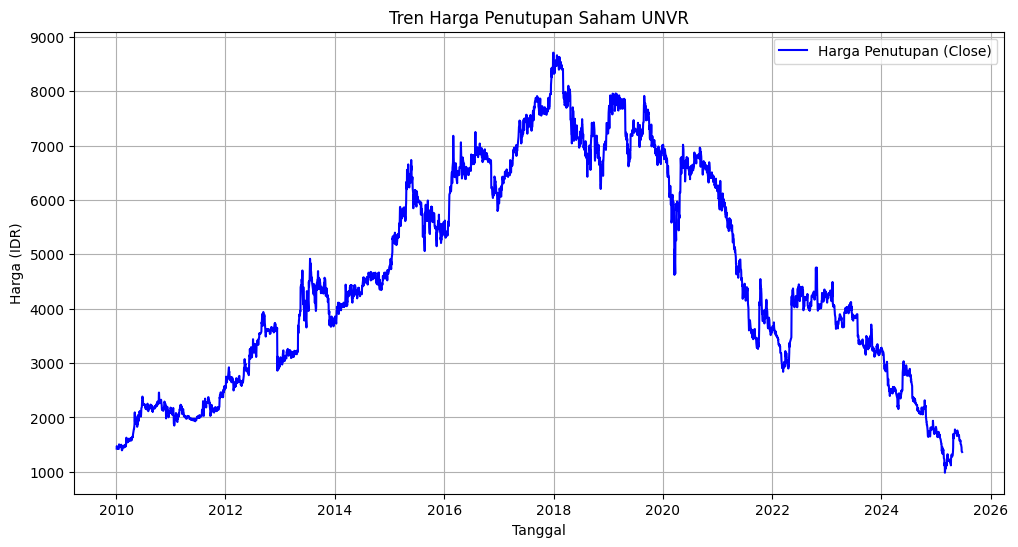

In [4]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Harga Penutupan (Close)', color='blue')
plt.title('Tren Harga Penutupan Saham UNVR')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.grid(True)
plt.legend()
plt.show()

## **🎯 Seleksi Kolom Target (Close)**

Karena tujuan dari proyek ini adalah memprediksi harga penutupan saham, maka kolom yang digunakan sebagai input utama hanyalah kolom `Close`. Kolom lain seperti Open, High, Low dan Volume tidak digunakan dalam model ini.


In [5]:
close_prices = data[['Close']]
close_prices.head()

Price,Close
Ticker,UNVR.JK
Date,
2010-01-04,1428.029785
2010-01-05,1473.261108
2010-01-06,1460.337402
2010-01-07,1434.491333
2010-01-08,1440.952881


# **Preprocessing**

## **🧹 Normalisasi Data**

Sebelum data dimasukkan ke dalam model LSTM, dilakukan proses normalisasi menggunakan `MinMaxScaler` agar semua nilai berada dalam rentang 0 hingga 1. Ini penting agar model neural network bisa belajar secara optimal, karena perbedaan skala data dapat memengaruhi proses pembelajaran.

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Kembalikan ke bentuk DataFrame untuk kemudahan pengolahan selanjutnya
scaled_data = pd.DataFrame(scaled_data, columns=['Close'], index=close_prices.index)
scaled_data.head()

,Close
Date,
2010-01-04,0.057446
2010-01-05,0.063304
2010-01-06,0.061630
2010-01-07,0.058283
2010-01-08,0.059120


## **📈 Transformasi ke Format Time Series untuk LSTM**

Model LSTM memerlukan data dalam bentuk 3 dimensi: `(samples, timesteps, features)`. Oleh karena itu, digunakan pendekatan sliding window.

Di sini digunakan:
- `n_past = 60` → model melihat 60 hari terakhir untuk memprediksi hari ke-61


In [7]:
X, y = [], []
n_past = 60

for i in range(n_past, len(scaled_data)):
    X.append(scaled_data.iloc[i - n_past:i].values)
    y.append(scaled_data.iloc[i].values)

X, y = np.array(X), np.array(y)

# C**reate Model 🧠**

### 🛠️ Membuat dan Melatih Model LSTM

Saya menggunakan model `Sequential` dengan dua lapisan LSTM berurutan. Lapisan pertama memiliki 64 unit dan lapisan kedua 32 unit, diakhiri dengan lapisan Dense berisi satu neuron karena kita memprediksi satu nilai.

In [8]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0458
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 6.5733e-04
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - loss: 5.6313e-04
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 5.6456e-04
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 5.3999e-04
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 5.0711e-04
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 4.6411e-04
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 4.5436e-04
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 4.7121e-04
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 4.1409e-04
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - loss: 4.3876e-04
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 4.3047e-04
Epoch 13/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 3.8392e-04
Epoch 14/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - 

# **Prediction 🔮**

### 🧾 Prediksi Harga 10 Hari ke Depan

Setelah model LSTM berhasil dilatih, saya melakukan prediksi harga saham untuk 10 hari ke depan. Proses ini tidak hanya memprediksi satu langkah ke depan, tetapi menggunakan pendekatan *recursive forecasting*, yaitu memprediksi hari pertama, lalu menggunakan prediksi tersebut sebagai input untuk memprediksi hari kedua, dan seterusnya hingga hari ke-10.

Langkah-langkahnya sebagai berikut:

1. **Ambil 60 Hari Terakhir sebagai Input Awal**  
   Saya ambil 60 data terakhir dari dataset `scaled_data`, karena model dilatih dengan menggunakan 60 langkah ke belakang (sliding window). Data ini direstrukturisasi ke bentuk `(1, 60, 1)` karena LSTM membutuhkan input 3 dimensi: `(samples, timesteps, features)`.

2. **Lakukan Prediksi Bertahap Selama 10 Hari (Iteratif)**  
   - Pada setiap iterasi, saya memprediksi satu nilai (`pred`) berdasarkan input 60 data sebelumnya.
   - Nilai prediksi ini ditambahkan ke `future_predictions`.
   - Lalu, `future_input` diperbarui dengan menggeser window ke depan: menghapus data paling awal dan menambahkan prediksi baru di akhir.
   - Ini dilakukan terus hingga mendapatkan 10 prediksi berturut-turut.

3. **Transformasi Kembali ke Skala Asli (Inverse Transform)**  
   Nilai prediksi yang dihasilkan masih dalam skala normalisasi (0–1), sehingga perlu dikembalikan ke skala harga sebenarnya menggunakan `scaler.inverse_transform()` agar interpretasi hasil lebih mudah dan bisa dibandingkan langsung dengan harga historis.

Dengan pendekatan ini, saya bisa mendapatkan estimasi harga saham UNVR untuk 10 hari mendatang dengan mempertahankan konteks historis 60 hari sebelumnya.

In [9]:
last_60_days = scaled_data[-60:]
future_input = last_60_days.values.reshape(1, 60, 1)

future_predictions = []
for _ in range(10):
    pred = model.predict(future_input)[0]
    future_predictions.append(pred)
    future_input = np.append(future_input[:, 1:, :], [[pred]], axis=1)

future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


### **📉 Visualisasi Hasil Prediksi**

Selanjutnya adalah memvisualisasikan harga historis 100 hari terakhir bersamaan dengan hasil prediksi 10 hari ke depan. Garis putus-putus berwarna oranye menunjukkan tren hasil prediksi dari model LSTM.

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


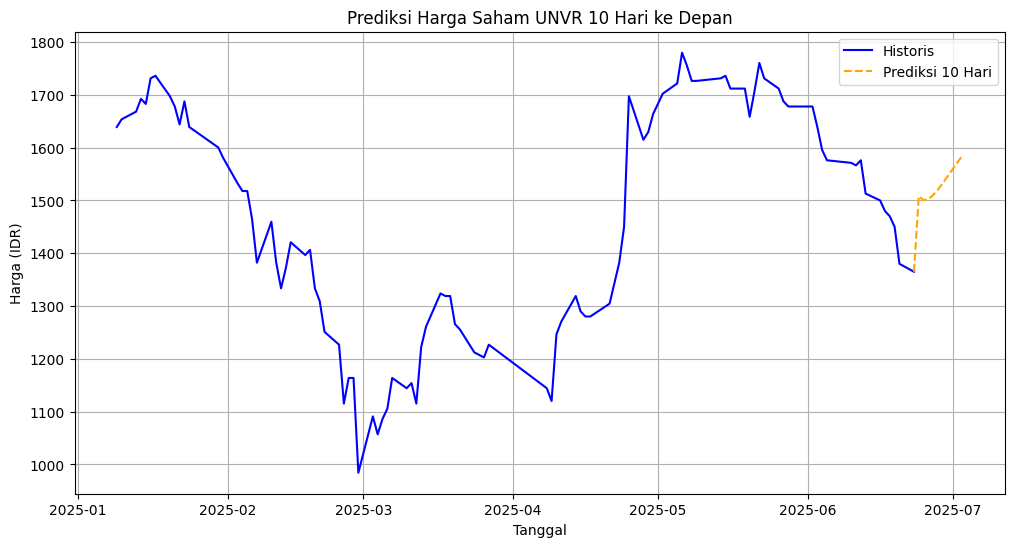

In [12]:
# Buat range tanggal untuk 10 hari ke depan
future_dates = pd.date_range(start=close_prices.index[-1] + pd.Timedelta(days=1), periods=10)

# Gabungkan harga terakhir + hasil prediksi
combined_prices = [close_prices.iloc[-1]['Close']] + future_predictions.flatten().tolist()
combined_dates = [close_prices.index[-1]] + list(future_dates)

# Buat DataFrame hasil prediksi
combined_df = pd.DataFrame({'Price': combined_prices}, index=combined_dates)

# Visualisasikan
plt.figure(figsize=(12,6))
plt.plot(close_prices[-100:], label='Historis', color='blue')
plt.plot(combined_df, label='Prediksi 10 Hari', color='orange', linestyle='--')
plt.title('Prediksi Harga Saham UNVR 10 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()

## **Analysis / Evaluation 📊**

### **🧪 Evaluasi Model**

Untuk menilai akurasi model, dataset dibagi menjadi 80% data latih dan 20% data uji. Setelah itu, saya prediksi nilai dari data uji dan bandingkan dengan nilai aktual. Beberapa metrik evaluasi yang dihitung, yaitu:
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

In [13]:
train_size = int(len(scaled_data) * 0.8)
test_data = scaled_data[train_size - n_past:]
X_test, y_test = [], []

for i in range(n_past, len(test_data)):
    X_test.append(test_data.iloc[i - n_past:i].values)
    y_test.append(test_data.iloc[i].values)

X_test, y_test = np.array(X_test), np.array(y_test)
predicted_test = model.predict(X_test)

predicted_prices = scaler.inverse_transform(predicted_test)
actual_prices = scaler.inverse_transform(y_test)

mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

print(f"\nHasil Evaluasi Model:")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Hasil Evaluasi Model:
MSE  : 15450.06
RMSE : 124.30
MAE  : 88.44
MAPE : 3.37%


Setelah model LSTM saya latih dan diuji menggunakan 20% data terakhir, berikut adalah hasil evaluasi model berdasarkan beberapa metrik umum dalam regresi:

- **Mean Squared Error (MSE): 15.450,06**
<br>Nilai MSE mengukur rata-rata dari kuadrat selisih antara harga aktual dan harga prediksi. Semakin kecil nilai MSE, semakin baik model dalam memprediksi. Dalam kasus ini, nilai 15 ribuan masih dalam batas wajar untuk data harga saham yang bervariasi.

- **Root Mean Squared Error (RMSE): 124,30**
<br>RMSE merupakan akar kuadrat dari MSE dan berada pada skala yang sama dengan harga saham (dalam satuan rupiah). Nilai ini menunjukkan bahwa rata-rata kesalahan prediksi model saya sekitar Rp124,30 dari nilai aktual. Ini cukup kecil dibandingkan harga saham UNVR yang biasanya berada di kisaran ribuan rupiah.

- **Mean Absolute Error (MAE): 88,44**
<br>MAE mengukur rata-rata dari selisih absolut (tanpa tanda) antara prediksi dan nilai aktual. Nilai ini menunjukkan rata-rata deviasi model dari harga sebenarnya adalah sekitar Rp88,44, yang cukup baik dalam konteks prediksi saham harian.

- **Mean Absolute Percentage Error (MAPE): 3,37%**
<br>MAPE menunjukkan rata-rata kesalahan prediksi dalam bentuk persentase terhadap nilai aktual. Nilai 3,37% mengindikasikan bahwa model saya hanya menyimpang sebesar ±3,37% dari harga sebenarnya. Untuk model time series saham, ini tergolong cukup akurat, terutama untuk data harian yang cenderung fluktuatif.

**Kesimpulan:**
<br>Dengan nilai MAPE di bawah 5%, model LSTM yang saya bangun dapat dikatakan efektif dalam memprediksi harga penutupan saham UNVR. Meskipun tidak sempurna, model ini menunjukkan tren yang cukup mendekati harga aktual.

### **📊 Visualisasi Evaluasi**

Hasil prediksi selanjutnya dibandingkan dengan data aktul dengan di visualkan ke dalam grafik

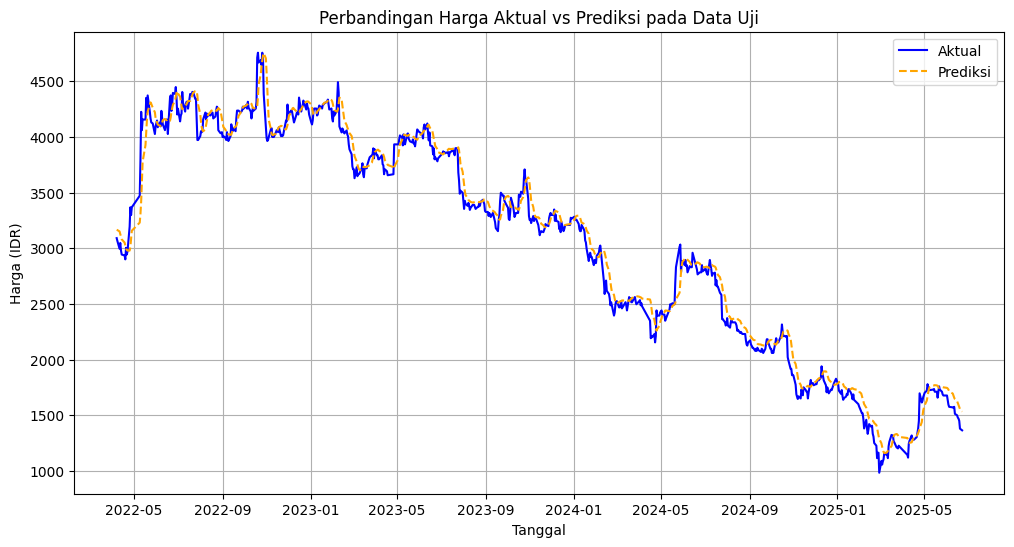

In [14]:
plt.figure(figsize=(12,6))
plt.plot(test_data.index[n_past:], actual_prices, label='Aktual', color='blue')
plt.plot(test_data.index[n_past:], predicted_prices, label='Prediksi', color='orange', linestyle='--')
plt.title('Perbandingan Harga Aktual vs Prediksi pada Data Uji')
plt.xlabel('Tanggal')
plt.ylabel('Harga (IDR)')
plt.legend()
plt.grid(True)
plt.show()

Grafik ini memberikan gambaran jelas tentang seberapa baik model dalam memprediksi harga saham dibandingkan dengan harga yang sebenarnya.